In [42]:
import pandas as pd
from matplotlib import pyplot as plt
from tabulate import tabulate
import numpy as np
import re
import locale
locale.setlocale(locale.LC_ALL, '')
import sys
import subprocess
from scipy.optimize import minimize
from matplotlib import rcParams
rcParams['figure.figsize'] = 9, 9

In [9]:
comps = pd.read_excel('tabulated_data2.xlsm', sheet_name='Compositions')
compNames = list(comps)[1:]
comps

Name McLeod-Mix1 McLeod-Mix2 McLeod-Mix3 McLeod-Mix22  \
0            Group      McLeod      McLeod      McLeod       McLeod   
1           Sample        Mix1        Mix2        Mix3        Mix22   
2               SG    0.705971    0.652476    0.609878     0.698439   
3    Inert Free SG    0.560051    0.558915    0.560063     0.681036   
4              CO2       0.005       0.003      0.0131        0.018   
..             ...         ...         ...         ...          ...   
111            NaN         NaN         NaN         NaN          NaN   
112            NaN         NaN         NaN         NaN          NaN   
113            NaN         NaN         NaN         NaN          NaN   
114            NaN         NaN         NaN         NaN          NaN   
115            NaN         NaN         NaN         NaN          NaN   

    McLeod-Mix24 McLeod-Mix25 Simon&Briggs-10PC Simon&Briggs-20PC API 37-Mix2  \
0         McLeod       McLeod      Simon&Briggs      Simon&Briggs      API 37   
1          Mix24        Mix25              10PC              20PC        Mix2   
2       0.741612      0.59657          0.616048          0.678315    0.789937   
3       0.736766     0.592865           0.55378           0.55378    0.718099   
4         0.0061        0.004                 0                 0      0.0209   
..           ...          ...               ...               ...         ...   
111          NaN          NaN               NaN               NaN         NaN   
112          NaN          NaN               NaN               NaN         NaN   
113          NaN          NaN               NaN               NaN         NaN   
114          NaN          NaN               NaN               NaN         NaN   
115          NaN          NaN               NaN               NaN         NaN   

     ... Custom-B1-D1 Custom-B1-D4 Custom-D-4088 Custom-D-4755 Custom-D-4469  \
0    ...       Custom       Custom        Custom        Custom        Custom   
1    ...        B1-D1        B1-D4        D-4088        D-4755        D-4469   
2    ...     0.920953     0.914739      1.478259      1.486924      1.491845   
3    ...     0.883728     0.875915      1.481586      1.490929      1.495805   
4    ...       0.0541       0.0556      0.010677      0.014265      0.014565   
..   ...          ...          ...           ...           ...           ...   
111  ...          NaN          NaN           NaN           NaN           NaN   
112  ...          NaN          NaN           NaN           NaN           NaN   
113  ...          NaN          NaN           NaN           NaN           NaN   
114  ...          NaN          NaN           NaN           NaN           NaN   
115  ...          NaN          NaN           NaN           NaN           NaN   

    Custom-D-4848 Custom-D-2580 Custom-D-4089 Custom-J1-D6 Custom-H4  
0          Custom        Custom        Custom       Custom    Custom  
1          D-4848        D-2580        D-4089        J1-D6        H4  
2         1.42351      1.448332      0.954684     0.912827  0.763508  
3        1.425305      1.450817       0.94823     0.873278  0.758088  
4        0.011568      0.014288      0.011178     0.059281  0.005303  
..            ...           ...           ...          ...       ...  
111           NaN           NaN           NaN          NaN       NaN  
112           NaN           NaN           NaN          NaN       NaN  
113           NaN           NaN           NaN          NaN       NaN  
114           NaN           NaN           NaN          NaN       NaN  
115           NaN           NaN           NaN          NaN       NaN  

[116 rows x 100 columns]

In [10]:
def make_valid_filename(input_string):
    valid_filename = re.sub(r'[^\w.-]', '_', input_string)
    valid_filename = valid_filename.strip()
    valid_filename = re.sub(r'[-_.]{2,}', '_', valid_filename)
    valid_filename = valid_filename.replace('@', '_').replace('#', '_')
    return valid_filename

In [11]:
R, mwAir, degF2R = 10.731577089016, 28.97, 459.67
class mix:
    def __init__(self, name, group, sample, sg, co2, h2s, n2, gas, coefic_pc, coefic_tc):
        self.comps = [co2, h2s, n2, gas]
        self.compnames = ['CO2', 'H2S', 'N2', 'Gas']
        self.name = make_valid_filename(name)
        self.group = group
        self.sample = sample
        self.sg = sg
        mws = np.array([44.01, 34.082, 28.014, 0])
        self.sg_hc = (sg - (co2 * mws[0] + h2s * mws[1] + n2 * mws[2]) / mwAir) / (1 - co2 - h2s - n2)
        mw_gas = self.sg_hc * mwAir
        self.pc = coefic_pc[0] * mw_gas + coefic_pc[1]
        self.tc = coefic_tc[0] * mw_gas + coefic_tc[1]         
        self.expmt = pd.read_excel('tabulated_data2.xlsm', sheet_name=name)
        
    def write_include(self, base_chr): # Write include files for 4 component model
        mws = np.array([44.01, 34.082, 28.014, 0])
        df = self.expmt.copy()
        temps = list(set(df['degf'].to_list()))
        temps.sort()
        
        out_str = 'DEFINE MW '+str(self.sg_hc * mwAir)+'\n'
        
        if self.sg_hc * mwAir < 0:
            print(self.comps)
            print(self.name)
            print(self.sample)
            print(self.sg)
            print(self.sg_hc)
            print(self.sg, self.comps[0], mws[0], self.comps[1], mws[1], self.comps[2], mws[2], mwAir)
            stop
        
        for temp in temps:
            out_str += 'DEFINE degR '+str(temp+459.67)+'\n\n'
            out_str += 'CHARACTERIZATION "CHR_'+self.name+'_'+str(temp)+'" BASE "'+base_chr+'"\n'
            header = ['COMPONENT', 'MW', 'TC,R', 'PC,PSIA', 'AF', 'VTRAN', 'A', 'B', 'AMOD', 'BMOD']
            rows = []
            for c in range(len(self.compnames)):
                rows.append([self.compnames[c], '', '', '', '', '', '', '', '', ''])
            rows[-1][1] = round(self.sg_hc * 28.97, 2)
            rows[-1][2] = round(self.tc,2)
            rows[-1][3] = round(self.pc,2)

            out_str += tabulate(rows, header)
            out_str += '\nEND\n\n'
            
            out_str += 'DEFINE degR_Slope CO2_degR_Slope, DEFINE MW_Slope CO2_MW_Slope, DEFINE Intcpt CO2_Intcpt, DEFINE Inert CO2\n'
            out_str += 'INCLUDE bips_calc.inc\n\n'
            
            out_str += 'DEFINE degR_Slope H2S_degR_Slope, DEFINE MW_Slope H2S_MW_Slope, DEFINE Intcpt H2S_Intcpt, DEFINE Inert H2S\n'
            out_str += 'INCLUDE bips_calc.inc\n\n'
            
            out_str += 'DEFINE degR_Slope N2_degR_Slope, DEFINE MW_Slope N2_MW_Slope, DEFINE Intcpt N2_Intcpt, DEFINE Inert N2\n'
            out_str += 'INCLUDE bips_calc.inc\n\n'
            
            BIP_HC = max(0.000160492*temp + 0.056787492, 1/(0.040933216*temp + 2.454878276))                  
            BIP_CN = 1/(-0.061940854*temp + -0.494913095)                     
            BIP_HN = -0.836144851 + (temp * 2.80825315) / (348.2693873 + temp)

            out_str += 'REPLACE BIP of H2S with CO2 by '+str(BIP_HC)+'\n'
            out_str += 'REPLACE BIP of CO2 with N2 by '+str(BIP_CN)+'\n'
            out_str += 'REPLACE BIP of H2S with N2 by '+str(BIP_HN)+'\n\n'
            
            out_str += 'REPLACE TC of Gas by ?MW? R\n'
            out_str += 'MULTIPLY TC of Gas by TC_slope\n'
            out_str += 'INCREASE TC of Gas by TC_int R\n\n'
            
            out_str += 'REPLACE PC of Gas by ?MW? psia\n'
            out_str += 'MULTIPLY PC of Gas by PC_slope\n'
            out_str += 'INCREASE PC of Gas by PC_int psia\n\n'
            
            out_str += 'MIX '+self.name+'_'+str(temp)+'\n'
            
            rows = []
            for c in range(len(self.compnames)):
                rows.append([self.compnames[c], self.comps[c]])
            out_str += tabulate(rows)
            out_str += '\nEND\n\n'
        
            out_str += 'QIX FEED 1 MOLE '+self.name+'_'+str(temp)+'\n'
            out_str += 'CCE ID "'+self.name+'_'+str(temp)+'"\n'

            exp_df = pd.DataFrame()
        
            filterd_df = df[df['degf'] == temp].copy()
            temps = filterd_df['degf'].to_list()+['Wt']
            press = filterd_df['psia'].to_list()+['']
            zs = filterd_df['Z'].to_list()+[1]
            gss = [1 for z in zs]
            gss[-1] = 0
            
            exp_df['TEMP (F)']= temps
            exp_df['PRES (psia)']= press
            exp_df['GZ']= zs
            exp_df['GS']= gss

            out_str += tabulate(exp_df, headers='keys', showindex='never', numalign='left')
            out_str += '\nEND\n\n'

        return out_str


In [12]:
phz_template = 'Inerts_PR_Match_VSHIFT_Only_AB_CO2_BigLoop_BIPS_Temp_reduced_MW_Slope4_Linear.phz' # The .Phz file to use as the base
#phz_template = 'Inerts_PR_Match_VSHIFT_Only_AB_CO2_BigLoop_BIPS_Temp_reduced_MW_Slope3_Orig_Omega.phz' # The .Phz file to use as the base


#Phz_loc = "C:\\Temp\\PhazeComp\\phazecomp.exe"         # The location of the PhazeComp executable on your system
Phz_loc = "C:\\Program Files\\PhazeComp\\1.81\\phazecomp.exe"         # The location of the PhazeComp executable on your system

def create_phz(phz_template):
    rms=float("nan")
    try:
        proc = subprocess.run([Phz_loc, phz_template,'NUL',">"], capture_output=True)
    except:
        print("Either phazecomp.exe couldnt be found (is it in "+Phz_loc+" ?), or "+phz_template+" couldn't be found - Exiting..")
        sys.exit()
    
    found_rms = False
    for i in range(len(proc.stderr.splitlines())-1,0,-1):
        line = proc.stderr.splitlines()[i].decode("utf-8")
        if "% RMS average weighted" in line:
            rms = float(line.split()[2])
            found_rms = True
            break
    if not found_rms:
        print("Error: No RMS for ",phz_template)
    return rms

In [13]:

def fn(x):
    coefic_pc = x[:2]
    coefic_tc = x[2:]
    comp_dic = {}
    for c in range(len(compNames)):
        name = compNames[c]
        group = comps.iloc[0, c+1]
        sample = comps.iloc[1, c+1]
        sg = comps.iloc[2, c+1]
        co2 = comps.iloc[4, c+1]
        h2s = comps.iloc[5, c+1]
        n2 = comps.iloc[6, c+1]
        gas = 1 - co2 - h2s - n2
        comp_dic[name] = mix(name, group, sample, sg, co2, h2s, n2, gas, coefic_pc, coefic_tc)
    
    # 4 component include files
    for c in range(len(compNames)):
        file_path = make_valid_filename(compNames[c])
        string = comp_dic[compNames[c]].write_include('RealGas')
        with open('.\\BigLoop_CO2AB_BIPS_Temp4_Linear\\'+file_path+'.inc', 'w') as file:
            file.write(string)
    
    #rms = create_phz(phz_template)
    #print(x, rms)
    return #rms

In [14]:
x0 = [-9.1258, 817.46, 5.2586, 252.04]
fn(x0)

In [22]:
#x0 = [-0.004289489, -4.521919227, 756.8, -0.08817282, 12.06420435, 169.2] # Base Sutton
# x0 = [-3.55897620e-03, -2.78434498e+00,  7.04262503e+02, -1.00841444e-01, 1.17914323e+01,  1.80343787e+02] # v3 previous best

x0 = [-9.1258, 817.46, 5.2586, 252.04]

bounds = [(-15, -5), (500, 1000), (2, 10), (150, 350)]
#bounds = [(-10, 2), (-10, 2), (3, 1000), (-10, 2), (-2, 50), (50, 500)]
sol = minimize(fn, x0, method='Nelder-Mead', bounds=bounds)

[ -9.1258 817.46     5.2586 252.04  ] 3.874
[ -9.58209 817.46      5.2586  252.04   ] 4.559
[ -9.1258 858.333    5.2586 252.04  ] 3.034
[ -9.1258  817.46      5.52153 252.04   ] 3.989
[ -9.1258 817.46     5.2586 264.642 ] 3.979
[ -8.66951  837.8965     5.390065 258.341   ] 2.868
[ -8.21322   848.11475     5.4557975 261.4915   ] 2.39
[ -8.66951    853.223875     5.09426875 263.06675   ] 2.612
[ -8.441365   871.1058125    5.27503313 249.677125  ] 2.784
[ -8.0991475  897.92871875   5.28324969 261.0976875 ] 2.786
[ -7.58582125 876.85357813   5.29557453 265.62653125] 2.487
[ -8.35581062 826.72028906   5.27708727 258.83326563] 2.74
[ -7.97081594 831.35043359   5.2863309  274.83189844] 2.457
[ -7.86387297 878.0510293    5.28889857 273.67507422] 2.4
[ -7.14735508 863.96102051   5.569032   274.74575195] 2.368
[ -6.38627762 869.32959326   5.80641363 280.58525293] 2.875
[ -8.01181074 833.88503857   5.50445496 276.74558105] 2.668
[ -7.69231862 866.11144324   5.34779464 268.4062937 ] 2.282
[ -7.487

[ -5.01448359 766.84458219   7.19013326 230.82720125] 1.493
[ -5.01449154 766.84180728   7.1901899  230.82608259] 1.493
[ -5.01448558 766.84388846   7.19014742 230.82692159] 1.493
[ -5.01448348 766.84475908   7.19013473 230.82699868] 1.493
[ -5.01445579 766.84160815   7.19022891 230.82479829] 1.493
[ -5.01449166 766.8434265    7.19016948 230.82693623] 1.493
[ -5.01446969 766.84399323   7.19017161 230.8263253 ] 1.493
[ -5.01447367 766.84260577   7.19019993 230.82576597] 1.493
[ -5.01447069 766.84364636   7.19017869 230.82618547] 1.493
[ -5.01446964 766.84408167   7.19017235 230.82622401] 1.493
[ -5.01445579 766.84250621   7.19021944 230.82512382] 1.493
[ -5.01447373 766.84341538   7.19018972 230.82619279] 1.493
[ -5.01446275 766.84369875   7.19019079 230.82588733] 1.493
[ -5.01446473 766.84300502   7.19020495 230.82560766] 1.493
[ -5.01446324 766.84352531   7.19019433 230.82581741] 1.493
[ -5.01446272 766.84374297   7.19019116 230.82583668] 1.493
[ -5.0144558  766.84295524   7.1902147  

In [61]:
# Run once at the end to ensure the directory of experiments reflects the solution case
fn(sol.x)

[-4.45842462e-03 -4.56650505e+00  7.34407484e+02 -8.97316576e-02
  1.08790638e+01  1.93914484e+02] 1.243


1.243

In [50]:
class solx:
    def __init__(self, x = [-3.78682503e-03, -2.78038939e+00,  7.03816710e+02, -9.85100535e-02, 1.17919736e+01,  1.79590669e+02]):
        self.x = x
        
sol = solx([-4.41997873e-03, -4.66832229e+00,  7.36742274e+02, -8.82275084e-02,   1.18700954e+01,  1.74473903e+02])

#sol = solx([-3.70657281e-03, -2.73168017e+00,  7.20789898e+02, -9.61269964e-02, 1.18647207e+01,  1.81862000e+02])


## Contrast custom critical properties with Sutton properties

In [52]:
def sutton(sg_hc):
    ppc_hc = 756.8 - 131.0 * sg_hc - 3.6 * sg_hc ** 2  # Eq 3.47b
    tpc_hc = 169.2 + 349.5 * sg_hc - 74.0 * sg_hc ** 2  # Eq 3.47a
    return (tpc_hc, ppc_hc)

# Modified Sutton Tc and Pc
def tc_pc(sg_hc):
    coefic_pc = sol.x[:3]
    coefic_tc = sol.x[3:]
    mw_gas = mwAir * sg_hc
    ppc_hc = coefic_pc[0] * mw_gas ** 2 + coefic_pc[1] * mw_gas + coefic_pc[2]
    tpc_hc = coefic_tc[0] * mw_gas ** 2 + coefic_tc[1] * mw_gas + coefic_tc[2] 
    return (tpc_hc, ppc_hc)
    

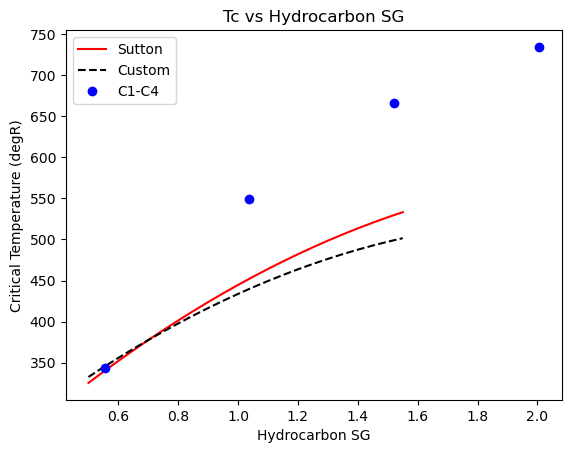

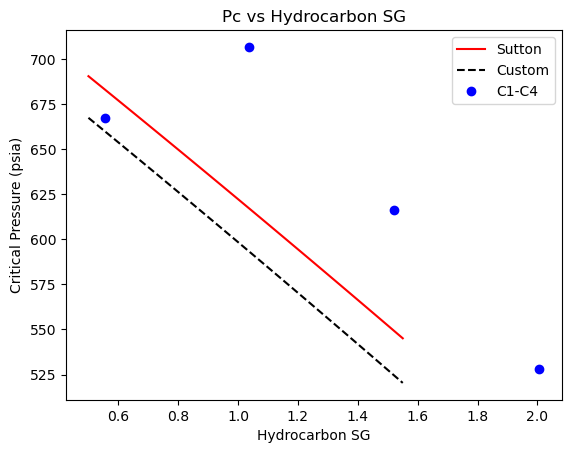

In [60]:
tc, pc = [[], []], [[], []]

sgs = np.arange(0.5, 1.6, 0.05)
for sg in sgs:
    sut_tc, sut_pc = sutton(sg)
    cust_tc, cust_pc = tc_pc(sg)
    tc[0].append(sut_tc)
    tc[1].append(cust_tc)
    pc[0].append(sut_pc)
    pc[1].append(cust_pc)

tc_scn = np.array([343.0080, 549.5760, 665.6940, 734.1300])
pc_scn = np.array([667.029, 706.624, 616.120, 527.937])
sg_scn = np.array([16.043, 30.070, 44.097, 58.123])/28.97

plt.plot(sgs, tc[0], '-', c='r', label='Sutton')
plt.plot(sgs, tc[1], '--', c='k', label='Custom')
plt.plot(sg_scn, tc_scn, 'o', c='b', label='C1-C4')
plt.title('Tc vs Hydrocarbon SG')
plt.xlabel('Hydrocarbon SG')
plt.ylabel('Critical Temperature (degR)')
plt.legend()
plt.savefig('tc.png')
plt.show()

plt.plot(sgs, pc[0], '-', c='r', label='Sutton')
plt.plot(sgs, pc[1], '--', c='k', label='Custom')
plt.plot(sg_scn, pc_scn, 'o', c='b', label='C1-C4')
plt.xlabel('Hydrocarbon SG')
plt.ylabel('Critical Pressure (psia)')
plt.title('Pc vs Hydrocarbon SG')
plt.legend()
plt.savefig('pc.png')
plt.show()

In [16]:
import pr_z_v4 as pr_eos
import importlib
importlib.reload(pr_eos)
import pyrestoolbox as rtb

In [41]:
pr_eos.calc_bips(39.440, 276)

array([[ 0.        ,  0.06738109, -0.06926812, -1.12300052],
       [ 0.06738109,  0.        ,  0.46618197,  0.24324815],
       [-0.06926812,  0.46618197,  0.        ,  0.42032465],
       [-1.12300052,  0.24324815,  0.42032465,  0.        ]])

In [17]:
df = pd.read_excel('Wichert_data_export.xlsx')
z_wichert = np.array(df['Z'])
degfs = np.array(df['degf'])
psias = np.array(df['psia'])
sgs = np.array(df['sg'])
co2s = np.array(df['co2'])
h2ss = np.array(df['h2s'])
n2s = np.array(df['n2'])
vol_wichert = R*(degfs + degF2R )*z_wichert/psias

#hc_mws = mwAir * (sgs - (co2s * 44.01 + h2ss * 34.082 + n2s * 28.014) / mwAir) / (1 - co2s - h2ss - n2s)

z_pr = np.array([pr_eos.peng_robinson_z(degfs[i], psias[i], sgs[i], co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i]) for i in range(len(degfs))])
vol_eos = R*(degfs + degF2R )*z_pr/psias
errs = np.abs(1 - z_pr / z_wichert)/z_wichert
np.where(errs > 0.05)

(array([  99,  119,  120,  704,  732,  748,  755,  764,  765,  766,  950,
         952,  953,  954,  955, 1060], dtype=int64),)

In [18]:
z_dak_pmc = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='PMC', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])
z_dak_sut = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='SUT', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])

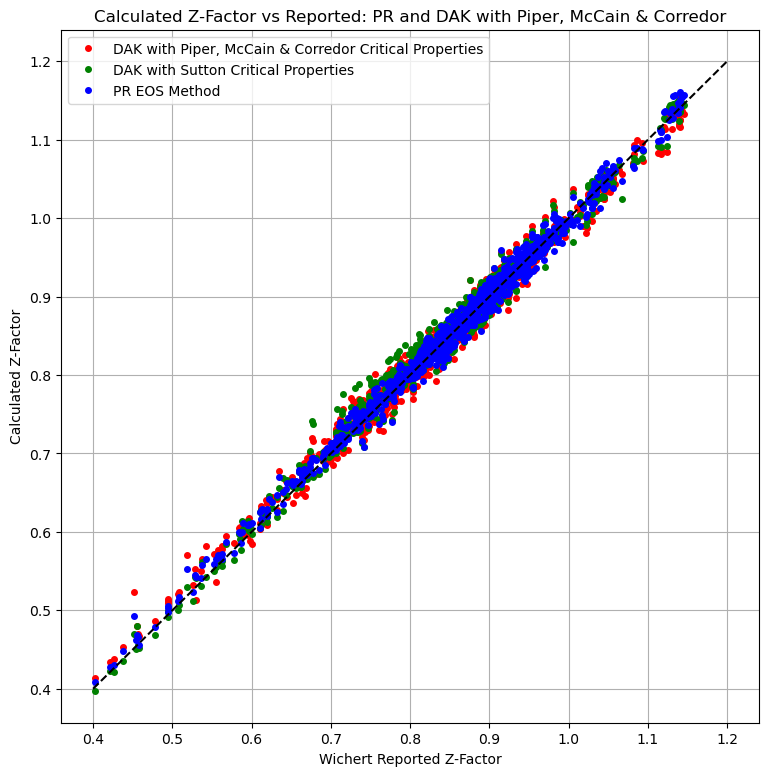

In [47]:

plt.plot(z_wichert, z_dak_pmc, 'o', c='r', markersize=4, label='DAK with Piper, McCain & Corredor Critical Properties')
plt.plot(z_wichert, z_dak_sut, 'o', c='g', markersize=4, label='DAK with Sutton Critical Properties')
plt.plot(z_wichert, z_pr, 'o', c='b', markersize=4, label='PR EOS Method')
plt.xlabel('Wichert Reported Z-Factor')
plt.ylabel('Calculated Z-Factor')
plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Calculated Z-Factor vs Reported: PR and DAK with Piper, McCain & Corredor')
plt.legend(loc='upper left')
plt.savefig('Crossplot_Z-PR_DAK.png')
plt.show()

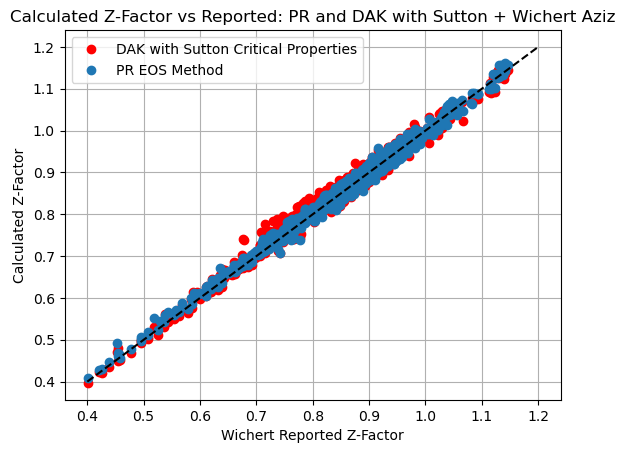

In [20]:
plt.plot(z_wichert, z_dak_sut, 'o', c='r', label='DAK with Sutton Critical Properties')
plt.plot(z_wichert, z_pr, 'o', label='PR EOS Method')
plt.xlabel('Wichert Reported Z-Factor')
plt.ylabel('Calculated Z-Factor')
plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Calculated Z-Factor vs Reported: PR and DAK with Sutton + Wichert Aziz')
plt.legend()
plt.show()

In [31]:
pr_er = (z_pr - z_wichert)/z_wichert
dak_sut_err = (z_dak_sut - z_wichert)/z_wichert
dak_pmc_err = (z_dak_pmc - z_wichert)/z_wichert

errs = [pr_er, dak_sut_err, dak_pmc_err]
names = ['Peng Robinson', 'DAK + Sutton & Wichert', 'DAK + PMC']
for e, err in enumerate(errs):
    avg = np.mean(err)
    maxerr = max(err)
    print(names[e], 'Avg Rel. Error: '+str(round(avg, 3))+', Max rel. Error: '+str(round(maxerr, 3)))

Peng Robinson Avg Rel. Error: 0.003, Max rel. Error: 0.089
DAK + Sutton & Wichert Avg Rel. Error: 0.007, Max rel. Error: 0.097
DAK + PMC Avg Rel. Error: 0.004, Max rel. Error: 0.157


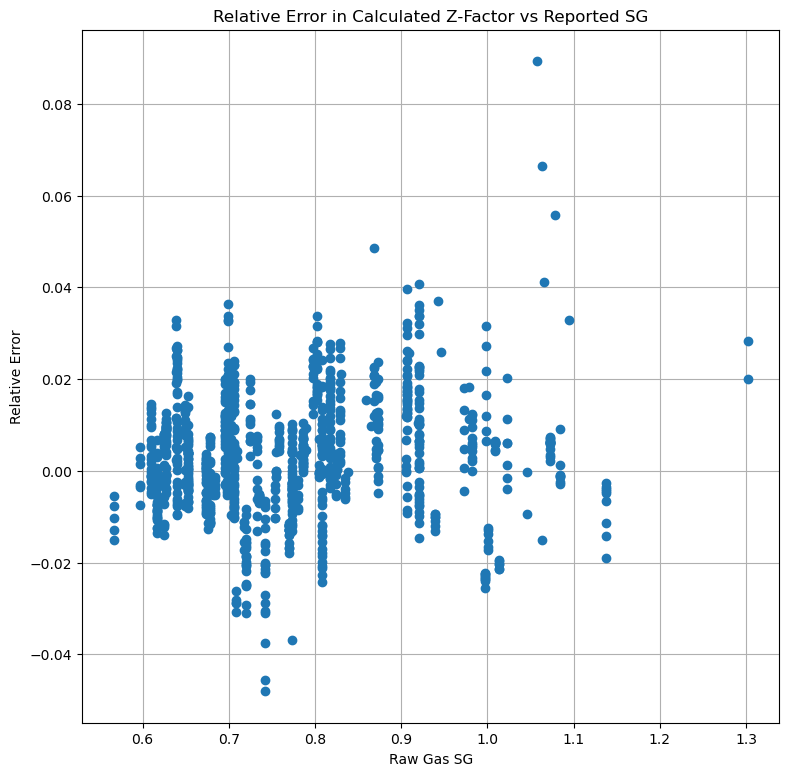

In [45]:
plt.plot(sgs, pr_er, 'o')
plt.xlabel('Raw Gas SG')
plt.ylabel('Relative Error')
#plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Relative Error in Calculated Z-Factor vs Reported SG')
#plt.legend()
plt.show()

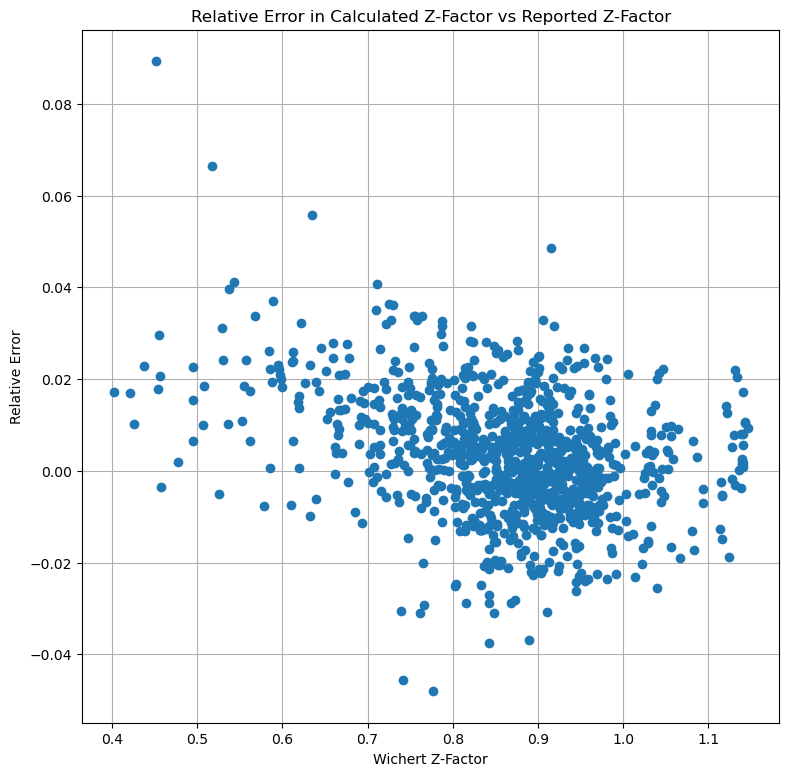

In [46]:
plt.plot(z_wichert, pr_er, 'o')
plt.xlabel('Wichert Z-Factor')
plt.ylabel('Relative Error')
#plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Relative Error in Calculated Z-Factor vs Reported Z-Factor')
#plt.legend()
plt.show()

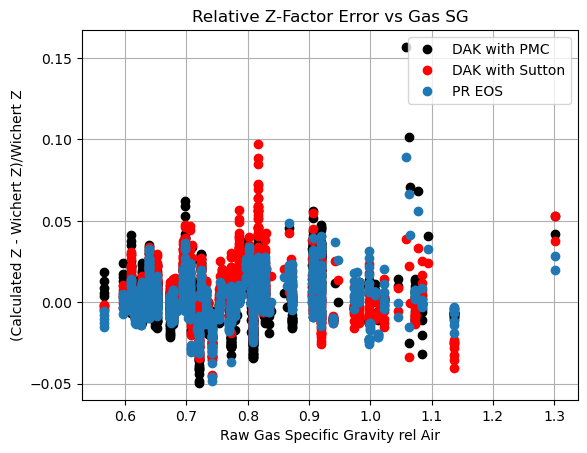

In [22]:
plt.plot(sgs, dak_pmc_err, 'o', c='k', label='DAK with PMC')
plt.plot(sgs, dak_sut_err, 'o', c='r', label='DAK with Sutton')
plt.plot(sgs, pr_er, 'o', label='PR EOS')

plt.xlabel('Raw Gas Specific Gravity rel Air')
plt.ylabel('(Calculated Z - Wichert Z)/Wichert Z')
#plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Relative Z-Factor Error vs Gas SG')
plt.legend()
plt.show()

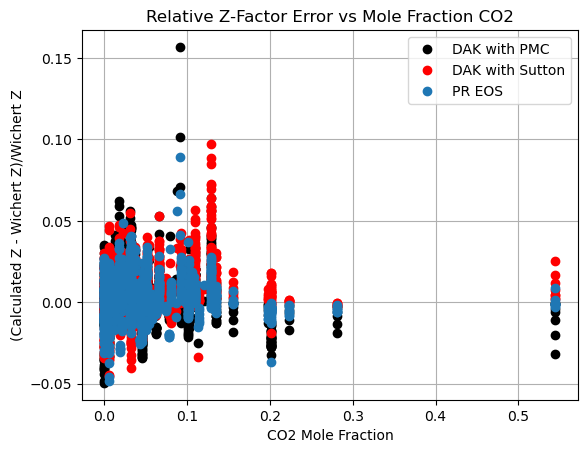

In [23]:
plt.plot(co2s, dak_pmc_err, 'o', c='k', label='DAK with PMC')
plt.plot(co2s, dak_sut_err, 'o', c='r', label='DAK with Sutton')
plt.plot(co2s, pr_er, 'o', label='PR EOS')

plt.xlabel('CO2 Mole Fraction')
plt.ylabel('(Calculated Z - Wichert Z)/Wichert Z')
#plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Relative Z-Factor Error vs Mole Fraction CO2')
plt.legend()
plt.show()

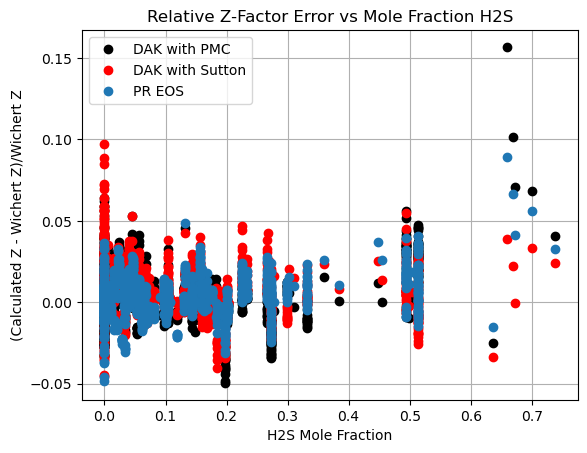

In [24]:
plt.plot(h2ss, dak_pmc_err, 'o', c='k', label='DAK with PMC')
plt.plot(h2ss, dak_sut_err, 'o', c='r', label='DAK with Sutton')
plt.plot(h2ss, pr_er, 'o', label='PR EOS')

plt.xlabel('H2S Mole Fraction')
plt.ylabel('(Calculated Z - Wichert Z)/Wichert Z')
#plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Relative Z-Factor Error vs Mole Fraction H2S')
plt.legend()
plt.show()

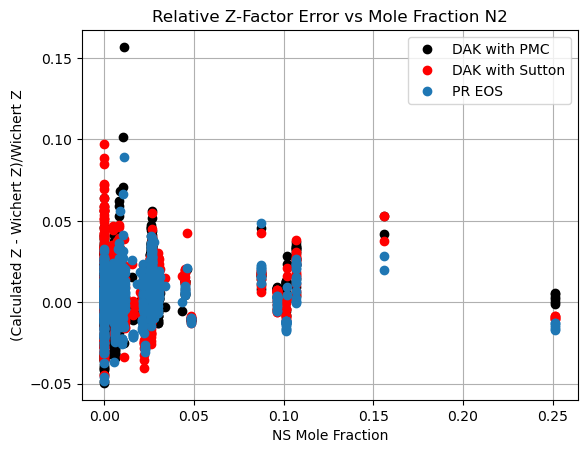

In [25]:
plt.plot(n2s, dak_pmc_err, 'o', c='k', label='DAK with PMC')
plt.plot(n2s, dak_sut_err, 'o', c='r', label='DAK with Sutton')
plt.plot(n2s, pr_er, 'o', label='PR EOS')

plt.xlabel('NS Mole Fraction')
plt.ylabel('(Calculated Z - Wichert Z)/Wichert Z')
#plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Relative Z-Factor Error vs Mole Fraction N2')
plt.legend()
plt.show()

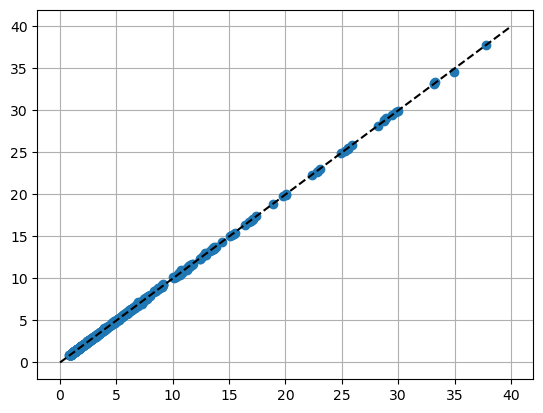

In [26]:
plt.plot(vol_wichert, vol_eos, 'o')
plt.plot([0, 40], [0, 40], '--', c='k')
plt.grid()
plt.show()